In [45]:
using MathProgBase, JuMP, NamedArrays, PyPlot, PyCall, Distributions, Mosek, Gurobi, Cbc, NLopt;

## Data Generation

In [3]:
function get_r(a,b,θ,ϕ)
    return 1/sqrt((cos(ϕ-θ)/a)^2+(sin(θ-ϕ)/b)^2)
end

function generate_ellipse(a, b, θ=0, n=100, noise=0)
    ϕ = sort(rand(n)*2*π)
    if noise == 0
        r = [ get_r(a,b,θ,i) for i in ϕ ]
    else
        r = [ get_r(a,b,θ,i)+rand(Normal(0, noise)) for i in ϕ ]
    end
    ellipsematrix = hcat(ϕ,r)
    return ellipsematrix
end

function generate_parametric_ellipse(a, b, θ=0, n=100, noise=0)
    ellipsematrix = generate_ellipse(a,b,θ,n,noise)
    x = [ellipsematrix[a,2]*cos(ellipsematrix[a,1]) for a in 1:length(ellipsematrix[:,1])]
    y = [ellipsematrix[a,2]*sin(ellipsematrix[a,1]) for a in 1:length(ellipsematrix[:,1])]
    ellipsematrix = hcat(x,y)
    return ellipsematrix
end;

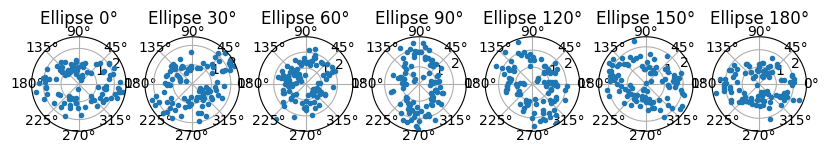

In [3]:
angles = [angle for angle in 0:π/6:π]
f1 = figure("Ellipses",figsize=(10,10))
for (i, angle) in enumerate(angles)
    data = generate_ellipse(2,1,angle,100,0.4)
    ax1 = subplot(1,length(angles),i, polar=true,)
    t = title(string("Ellipse ",(i-1)*30,"°"))
    pl1 = plot( data[:,1], data[:,2], linestyle="None", marker="." ) ;
    ax1[:set_theta_zero_location]("E") ;
end

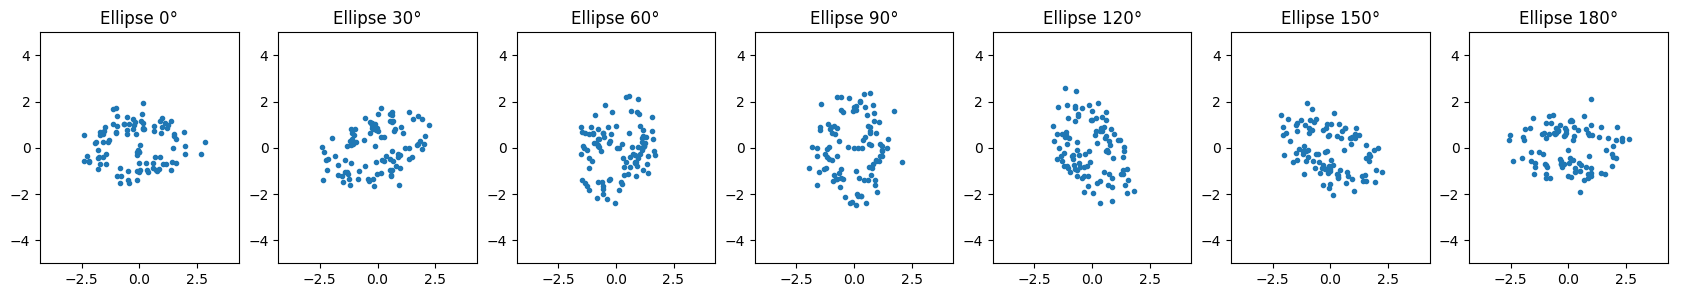

In [4]:
angles = [angle for angle in 0:π/6:π]
f1 = figure("Ellipses",figsize=(3*length(angles),3))
for (i, angle) in enumerate(angles)
    data = generate_parametric_ellipse(2,1,angle,100,0.4)
    ax1 = subplot(1,length(angles),i)
    t = title(string("Ellipse ",(i-1)*30,"°"))
    pl1 = plot( data[:,1], data[:,2], linestyle="None", marker="." ) ;
    axis("equal");
    ax1[:set_ylim]([-5,5])
    ax1[:set_xlim]([-5,5])
end

## Approximation of a Single Ellipse (No Noise)

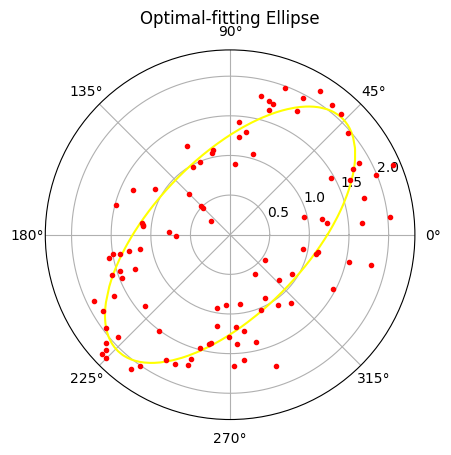

2.038889051385687 0.974002186907976 0.8047898783347447


In [44]:
#Create an ellipse dataset
datasize = 100
rawdata = generate_ellipse(2,1,π/4,datasize,0.3)
angles = vec(rawdata[:,1])
oradii = vec(rawdata[:,2])
#no_noise_single_model = Model(solver=MosekSolver(MSK_IPAR_LOG=0))
no_noise_single_model = Model(solver=NLoptSolver(algorithm=:LN_COBYLA))
@variable(no_noise_single_model, a>=0)
@variable(no_noise_single_model, b>=0)
@variable(no_noise_single_model, π>=θ>=0)
@NLexpression(no_noise_single_model, e[i=1:length(angles)],1/sqrt((cos(angles[i]-θ)/a)^2+(sin(θ-angles[i])/b)^2))
@NLobjective(no_noise_single_model, Min, sum((oradii[i]-e[i])^2 for i in 1:length(angles)))
setvalue(a, 1)
setvalue(b, 1)
setvalue(θ, π/2)
s = solve(no_noise_single_model)
opt_a = getvalue(a)
opt_b = getvalue(b)
opt_θ = getvalue(θ)
opt_e = getvalue(e)
println(string(opt_a, " ",opt_b, " ",opt_θ))

optdata = generate_ellipse(opt_a,opt_b,opt_θ,500,0)
ax1 = subplot(1,1,1, polar=true,)
title("Optimal-fitting Ellipse")
po = plot( optdata[:,1], optdata[:,2], linestyle="-", marker="None",color="yellow" ) ;
pr = plot( rawdata[:,1], rawdata[:,2], linestyle="None", marker=".",color="red") ;
ax1[:set_theta_zero_location]("E") ;

$C = \begin{bmatrix}
0 & 0 & 2 & 0 & 0 & 0 \\
0 &-1 & 0 & 0 & 0 & 0 \\
2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$

$D = \begin{bmatrix}
x^2_1 & xy_1 & y^2_1 & x_1 & y_1 & 1_1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x^2_n & xy_n & y^2_n & x_n & y_n & 1_n
\end{bmatrix}$

Model


$\begin{equation*}
\begin{aligned}
& \underset{a, \lambda}{\text{minimize}}
& & \left\lVert Da\right\rVert_2^2 \\
& \text{subject to}
& & a^TCa = 1\\
&&& (D^TD - \lambda C)a = 0\\
\end{aligned}
\end{equation*}$

In [164]:
# Create a constriant matrix to make sure the conic is an ellipse
C = [0  0 2 0 0 0
     0 -1 0 0 0 0
     2  0 0 0 0 0
     0  0 0 0 0 0
     0  0 0 0 0 0
     0  0 0 0 0 0]
I = [1 0 0 0 0 0
     0 1 0 0 0 0
     0 0 1 0 0 0
     0 0 0 1 0 0
     0 0 0 0 1 0
     0 0 0 0 0 1]

#Create an ellipse dataset
datasize = 100
rawdata = generate_parametric_ellipse(2,1,π/4,datasize,0)
x2 = vec([i*i for i in rawdata[:,1]])
y2 = vec([i*i for i in rawdata[:,2]])
x = vec(rawdata[:,1])
y = vec(rawdata[:,2])
xy = vec([rawdata[i,1]*rawdata[i,2] for i in 1:datasize])
o = vec(ones(datasize))
datamatrix = [x2 xy y2 x y o]
scattermatrix = transpose(datamatrix)*datamatrix
#print(string("Scatter Eigenvalues: ",eigs(scattermatrix, nev=5)[1],"\n"))
print(string("GEV: ",eigs(scattermatrix - C, sigma=.1),"\n"))
#print(string("C Eigenvalues: ",eigs(C, nev=5)[1],"\n"))

GEV: ([-0.433256,50.1887,73.1929,89.075,123.304],
[-0.409992 0.00231284 0.344495 0.612426 0.0884625; 0.482873 -0.675724 -0.382458 0.240791 -0.0287838; -0.410343 -0.0092525 -0.371623 -0.585074 -0.141828; -0.000844328 -0.382411 0.579894 -0.21087 -0.687574; 0.000598683 0.393475 -0.436092 0.392717 -0.705916; 0.656017 0.492185 0.265506 -0.161087 -0.0124815],

5,1,6,[0.0,0.0,0.0,0.0,0.0,0.0])


In [191]:
# Create a model
no_noise_single_model = Model(solver=MosekSolver(MSK_IPAR_LOG=0))
@variable(no_noise_single_model, a[1:6],)
@variable(no_noise_single_model, l >=0) #With or without this constraint it fails
# Constrain the solution to be an ellipse
@expression(no_noise_single_model, SlC, scattermatrix-l*I*C)
@constraint(no_noise_single_model, SlC*a .>= 0)
@constraint(no_noise_single_model, SlC*a .<= 0)
@constraint(no_noise_single_model, transpose(a)*C*a .>= 1)
@constraint(no_noise_single_model, transpose(a)*C*a .<= 1)
@expression(no_noise_single_model, errormatrix, datamatrix*a)
# Minimize the error
@objective(no_noise_single_model, Min, sum(errormatrix[i]^2 for i in 1:datasize))
s = solve(no_noise_single_model)
println(getvalue(a))

[NaN,NaN,NaN,NaN,NaN,NaN]


In [ ]:
# ax1 = subplot(1,1,1)
# t = title("Ellipse ")
# pl1 = plot( x, y, linestyle="None", marker="." ) ;
# axis("equal");
# ax1[:set_ylim]([-5,5])
# ax1[:set_xlim]([-5,5])
# opt_a = getvalue(a)
# opt_b = getvalue(b)
# opt_θ = getvalue(θ)
# opt_e = getvalue(e)

# optdata = generate_ellipse(opt_a,opt_b,opt_θ,500,0)
# ax1 = subplot(1,1,1)
# title("Optimal-fitting Ellipse")
# po = plot( optdata[:,1], optdata[:,2], linestyle="-", marker="None",color="yellow" ) ;
# pr = plot( rawdata[:,1], rawdata[:,2], linestyle="None", marker=".",color="red") ;
# ax1[:set_theta_zero_location]("E") ;

In [170]:
# Create a model
no_noise_single_model = Model(solver=MosekSolver(MSK_IPAR_LOG=0))
@variable(no_noise_single_model, u[1:6],)
@variable(no_noise_single_model, λ)
# Constrain the solution to be an ellipse
@expression(no_noise_single_model, SlC, scattermatrix - λ*I*C)
@expression(no_noise_single_model, vals, sum(for i in SlC*u))
# Minimize the error
@objective(no_noise_single_model, Min, sum(i^2 for i in vals))
s = solve(no_noise_single_model)
println(getvalue(a))

LoadError: *(::QuadExpr,::QuadExpr) is not defined. Are you trying to build a nonlinear problem? Make sure you use @NLconstraint/@NLobjective.